<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/InriaAerialImages/Inria_SlidingWindowPatches_256_wpad_overlap_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inria Aerial Satellite Image Labelling

The main aim of this challenge is to be able to classify pixels as 'building' or 'not building'. This is a clear case of semantic segmentation. We have180 aerial images from various cities with a resolution of 5000 X 5000, along with the segmented masks of 5000 X 5000. Our goal is to classify each of the pixels in the test image and generate a masks for the test images too.

**Project Notebook created by : Pallavi Allada, Jhansi Anumula, Zoheb Abai**

In [0]:
# Setting up fastai in colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Download Preprocessed data from drive to colab

For code of preprocessing the data of creating sliding window patches check this [notebook](https://github.com/fellowship/platform-demos3/blob/master/InriaAerialImages/Inria_Preprocessing_SlidingWindowPatches_250.ipynb) 

In [0]:
# Copying the tar file to colab memory
!mkdir 'InriaPatches'
!cp 'drive/My Drive/256_tif_files/train.tar' 'InriaPatches/'
!cp 'drive/My Drive/256_tif_files/valid.tar' 'InriaPatches/'
!cp 'drive/My Drive/256_tif_files/masks.tar' 'InriaPatches/'
# !cp 'drive/My Drive/256_tif_files/test.tar' 'InriaPatches/'

In [0]:
# Untar the tar files
!tar -zxf InriaPatches/train.tar -C InriaPatches/
!tar -zxf InriaPatches/valid.tar -C InriaPatches/
!tar -zxf InriaPatches/masks.tar -C InriaPatches/
# !tar -zxf InriaPatches/test.tar -C InriaPatches/

In [0]:
# Remove all the tar files
!rm -rf InriaPatches/*.tar

## EDA

Import required fastai libraries

In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
print(fastai.__version__)

1.0.52


Check the sample images and their dimensions in train and test folders

In [0]:
root_dir = Path('InriaPatches')
train_path = root_dir/'train'
valid_path = root_dir/'valid'
mask_path = root_dir/'masks'
# test_path = root_dir/'test'

In [0]:
train = get_image_files(train_path)
valid = get_image_files(valid_path)
masks = get_image_files(mask_path)
# test = get_image_files(test_path)
len(train),len(valid), len(masks)#, len(test)

(62000, 10000, 72000)

In [0]:
# Size of each image and its mask
image = open_image(train[0])
img_size = np.array(image.shape[1:])
print(image.shape)

mask = open_mask(masks[0], div=True)
print(mask.shape)
mask_size = np.array(mask.shape[1:])

np.unique(np.array(mask.data))

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


array([0, 1])

Function to get the corresponding mask file (labels) of an image file (inputs)

In [0]:
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'
img = train[0]
img, get_mask_file(img)

(PosixPath('InriaPatches/train/austin25_45.tif'),
 PosixPath('InriaPatches/masks/austin25_45.tif'))

## Data Viz.

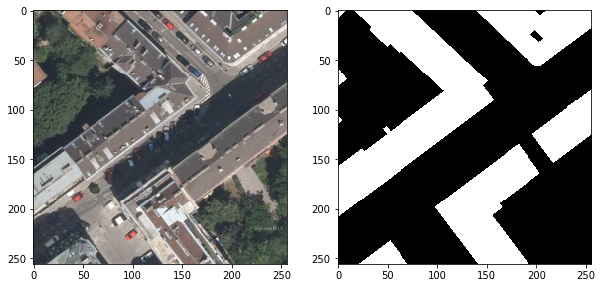

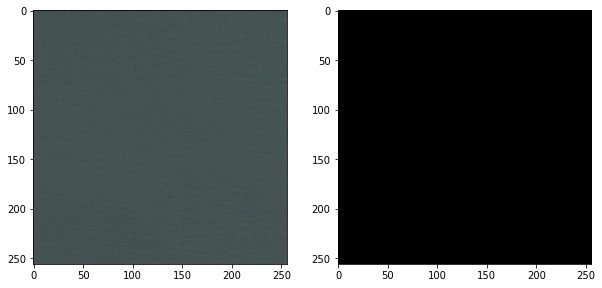

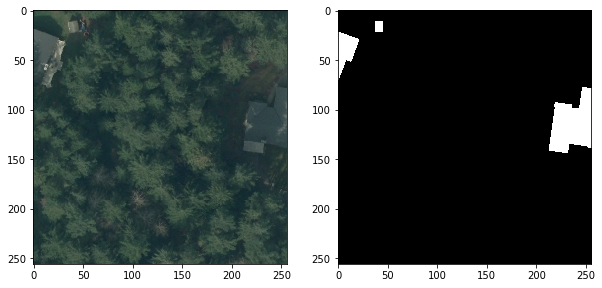

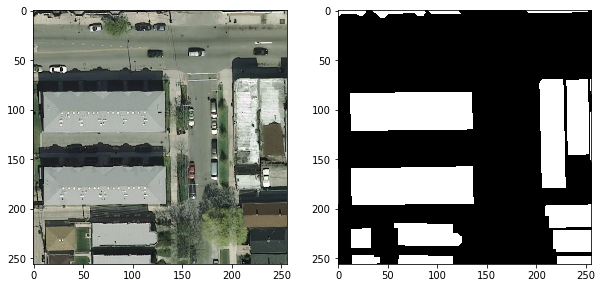

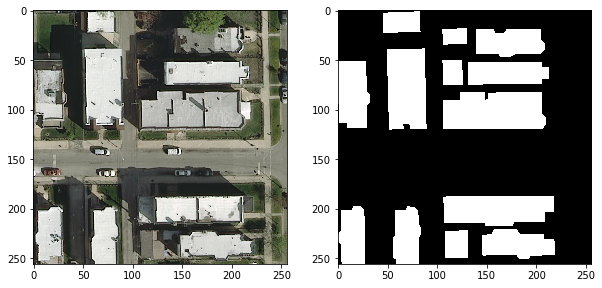

In [0]:
import matplotlib.pyplot as plt

'''Display a sample of random images as their corresponding masks'''
def display_image_mask_grid(n):
  images_list = []
  for i in range(n):
    images_list.append(random.choice(os.listdir(train_path)))
  for idx, image in enumerate(images_list):  
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    img = plt.imread(str(train_path/image))
    axs[0].imshow(img)
    msk = plt.imread(str(mask_path/image))
    axs[1].imshow(msk, cmap='gray')    
    plt.grid(False)
    plt.show()  
    

display_image_mask_grid(5)

## U-Net Model

In [0]:
# Parameters
codes = np.array(['NotBuilding','Building'])
src_size = np.array(mask.shape[1:])
size = src_size
bs = 16
size, bs

(array([256, 256]), 16)

In [0]:
# Subclass the segmentation label list to get masked values within 0 and 1
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False

In [0]:
# Using datablock api generate the databunch for training and validation set
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder('train','valid').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.2, max_warp=0.) 
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

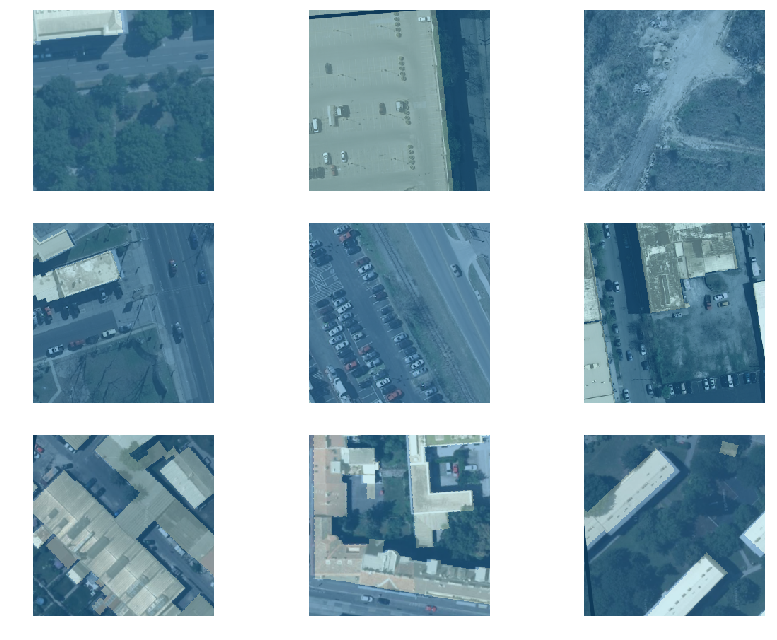

In [0]:
# Visualizing a batch from databunch
data.show_batch(rows=3, figsize=(12,9))

In [0]:
# Display data(x,y) in train and validation sets
len(data.train_ds.x.items), len(data.train_ds.y.items),len(data.valid_ds.x.items), len(data.valid_ds.y.items)

(62000, 62000, 10000, 10000)

In [0]:
# Labels
data.classes

array(['NotBuilding', 'Building'], dtype='<U11')

### Custom Loss

In [0]:
def jaccard_loss(input, target):
  smooth = 1.
  input = input[:,1,None].sigmoid()
  iflat = input.contiguous().view(-1).float()
  tflat = target.view(-1).float()
  intersection = (iflat * tflat).sum()
  cardinality = (iflat + tflat).sum()
  union = cardinality - intersection
  return (1 - ((intersection + smooth) / (union + smooth)))

def combo_loss(pred, targ):
  bce_loss = CrossEntropyFlat(axis=1)
  return bce_loss(pred,targ) + jaccard_loss(pred,targ)

In [0]:
# Defining Metrics
iou = partial(dice, iou=True)
metrics = [combo_loss, accuracy_thresh, iou] # add Jaccard_loss in metrics instead of combo_loss in future

In [0]:
# Defining the Model. Using pretrained resnet 18 model as encoder.
learn = unet_learner(data, models.resnet18, loss_func = combo_loss, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 147460515.88it/s]


## First Stage of Training the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


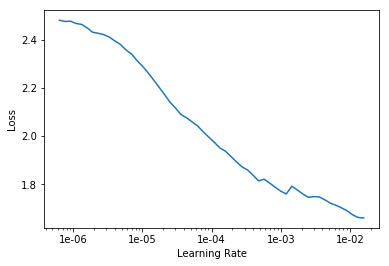

In [0]:
# Freeze the model and plot the Loss- Lr curve
learn.freeze()
learn.lr_find()
learn.recorder.plot()

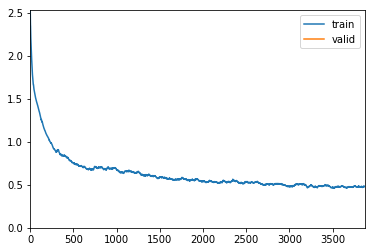

Better model found at epoch 0 with dice value: 0.6718345880508423.


In [0]:
# Training the model for 5 epochs
learn.fit_one_cycle(1, max_lr=1e-04, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='dice', name='bestIOU')])

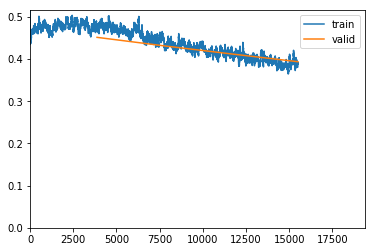

Better model found at epoch 0 with dice value: 0.6691816449165344.
Better model found at epoch 1 with dice value: 0.6866805553436279.
Better model found at epoch 2 with dice value: 0.7015611529350281.
Better model found at epoch 3 with dice value: 0.7105882167816162.
Buffered data was truncated after reaching the output size limit.

In [0]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=1e-04, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='dice', name='bestIOU')])

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/models/bestIOU.pth' 'drive/My Drive/256_tif_files/bestIOU_1.pth'

In [0]:
learn.export("bestIOU_1.pkl")

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/bestIOU_1.pkl' 'drive/My Drive/256_tif_files/bestIOU_1.pkl'

### Fine-tuning the Model

In [0]:
# Using datablock api generate the databunch for training and validation set
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder('train','valid').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.2, max_warp=0.) 
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

In [0]:
# Defining the Model. Using pretrained resnet 18 model as encoder.
learn = unet_learner(data, models.resnet18, loss_func = combo_loss, metrics=metrics)
learn.metrics = metrics
learn.loss_func = combo_loss

In [0]:
# Copy the model from gdrive
!cp 'drive/My Drive/256_tif_files/bestIOU_1.pth' 'InriaPatches/models/'

In [0]:
# Load the trained model
learn = learn.load("bestIOU_1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


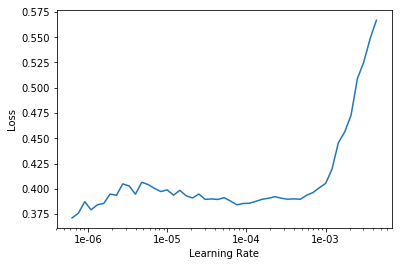

In [0]:
# Un-Freeze the model and plot the Loss- Lr curve
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

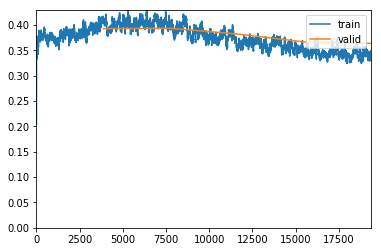

Better model found at epoch 0 with dice value: 0.7189212441444397.
Better model found at epoch 1 with dice value: 0.7215041518211365.
Better model found at epoch 2 with dice value: 0.7259674668312073.
Better model found at epoch 3 with dice value: 0.734337329864502.
Better model found at epoch 4 with dice value: 0.7387723922729492.


In [0]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-04), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='dice', name='bestIOU')])

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/models/bestIOU.pth' 'drive/My Drive/256_tif_files/bestIOU_2.pth'

In [0]:
learn.export("bestIOU_2.pkl")

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/bestIOU_2.pkl' 'drive/My Drive/256_tif_files/'

### Tuning Again

In [0]:
learn.unfreeze()

In [0]:
# Copy the model from gdrive
!cp 'drive/My Drive/256_tif_files/bestIOU_2.pth' 'InriaPatches/models/'

In [0]:
# Load the trained model
learn = learn.load("bestIOU_2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


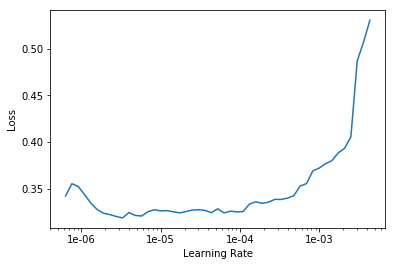

In [0]:
learn.lr_find()
learn.recorder.plot()

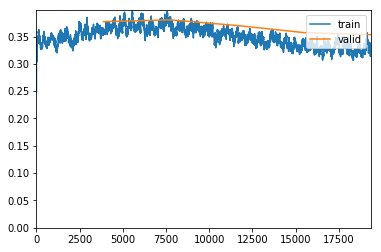

Better model found at epoch 0 with dice value: 0.7341004610061646.
Better model found at epoch 3 with dice value: 0.7448698282241821.
Better model found at epoch 4 with dice value: 0.7473427653312683.


In [0]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-04), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='dice', name='bestIOU')])

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/models/bestIOU.pth' 'drive/My Drive/256_tif_files/bestIOU_3.pth'

In [0]:
learn.export("bestIOU_3.pkl")

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/bestIOU_3.pkl' 'drive/My Drive/256_tif_files/'

## Second Stage of Training the Model

Since this training we want our model to not implement rotation as Image Augmentation. Add max_rotate=0 in get_transforms during 2nd and final stage of training

In [0]:
# Using datablock api generate the databunch for training and validation set
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder('train','valid').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.2, max_warp=0., max_rotate=0.)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

In [0]:
# Defining the Model. Using pretrained resnet 18 model as encoder.
learn = unet_learner(data, models.resnet18, loss_func = combo_loss, metrics=metrics)
# learn.metrics = metrics
# learn.loss_func = combo_loss

In [0]:
# Copy the model from gdrive
!cp 'drive/My Drive/256_tif_files/bestIOU_3.pth' 'InriaPatches/models/'

In [0]:
# Load the trained model
learn = learn.load("bestIOU_3")

In [0]:
# Freeze the model and plot the Loss- Lr curve
learn.freeze()
learn.lr_find()
learn.recorder.plot()

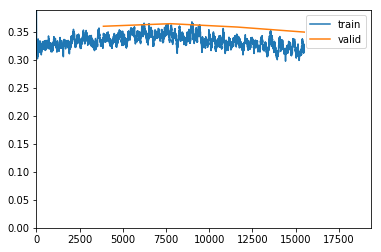

Better model found at epoch 0 with dice value: 0.7450052499771118.
Better model found at epoch 2 with dice value: 0.7485821843147278.
Better model found at epoch 3 with dice value: 0.7516261339187622.
Buffered data was truncated after reaching the output size limit.

In [0]:
# Training the model for 5 epochs
lr = 1e-04
learn.fit_one_cycle(5, max_lr=lr, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='dice', name='bestIOU')])

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/models/bestIOU.pth' 'drive/My Drive/256_tif_files/bestIOU_4.pth'

In [0]:
learn.export("bestIOU_4.pkl")

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/bestIOU_4.pkl' 'drive/My Drive/256_tif_files/'

### Fine-tuning

In [0]:
# Using datablock api generate the databunch for training and validation set
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder('train','valid').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.2, max_warp=0., max_rotate=0.)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

In [0]:
# Defining the Model. Using pretrained resnet 18 model as encoder.
learn = unet_learner(data, models.resnet18, loss_func = combo_loss, metrics=metrics)
# learn.metrics = metrics
# learn.loss_func = combo_loss

In [0]:
# Copy the model from gdrive
!cp 'drive/My Drive/256_tif_files/bestIOU_4.pth' 'InriaPatches/models/'

In [0]:
# Load the trained model
learn = learn.load("bestIOU_4")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05


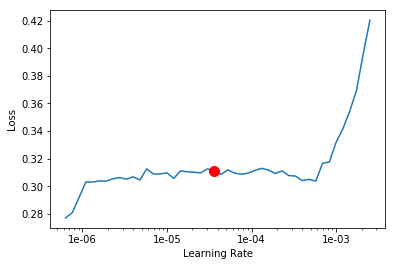

In [0]:
# Un-Freeze the model and plot the Loss- Lr curve
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

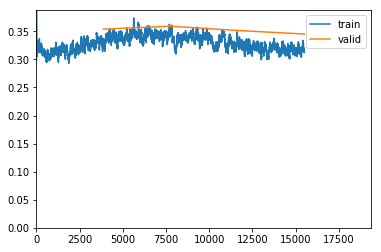

Better model found at epoch 0 with dice value: 0.7486863732337952.
Better model found at epoch 2 with dice value: 0.7493554949760437.
Better model found at epoch 3 with dice value: 0.754111111164093.
Buffered data was truncated after reaching the output size limit.

In [0]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-04), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='dice', name='bestIOU')])

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/models/bestIOU.pth' 'drive/My Drive/256_tif_files/bestIOU_5.pth'

In [0]:
learn.export("bestIOU_5.pkl")

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/bestIOU_5.pkl' 'drive/My Drive/256_tif_files/'

## Final Stage of Training the Model 

In [0]:
# Using datablock api generate the databunch for training and validation set
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder('train','valid').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.2, max_warp=0., max_rotate=0.)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

In [0]:
# Defining the Model. Using pretrained resnet 18 model as encoder.
learn = unet_learner(data, models.resnet18, loss_func = combo_loss, metrics=metrics)

In [0]:
# Copy the model from gdrive
!cp 'drive/My Drive/256_tif_files/bestIOU_5.pth' 'InriaPatches/models/'

In [0]:
# Load the trained model
learn = learn.load("bestIOU_5")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


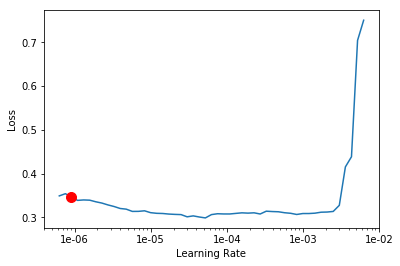

In [0]:
# Freeze the model and plot the Loss- Lr curve
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

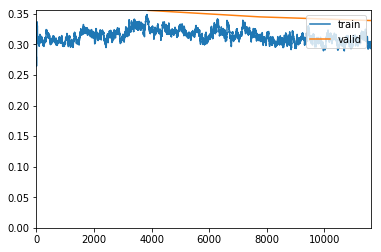

Better model found at epoch 0 with dice value: 0.7480174899101257.
Better model found at epoch 1 with dice value: 0.7526506781578064.
Better model found at epoch 2 with dice value: 0.7569883465766907.


In [0]:
#Training the model for 5 epochs
learn.fit_one_cycle(3, slice(1e-5,1e-04), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='dice', name='bestIOU')])

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/models/bestIOU.pth' 'drive/My Drive/256_tif_files/bestIOU_6.pth'

In [0]:
learn.export("bestIOU_6.pkl")

In [0]:
# Copy the best model to gdrive for later use
!cp 'InriaPatches/bestIOU_6.pkl' 'drive/My Drive/256_tif_files/'

**There is an extreme saturation of Accuracy and IOU value. So we stop our training here.And considering best_IOU5.pth file as final model.**

## Prediction and Visualization on Validation Dataset

In [0]:
# Using datablock api generate the databunch for training and validation set
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder('train','valid').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.2, max_warp=0., max_rotate=0.)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

In [0]:
# Defining the Model. Using pretrained resnet 18 model as encoder.
learn = unet_learner(data, models.resnet18, loss_func = combo_loss, metrics=metrics)

In [0]:
# Copy the model from gdrive
!cp 'drive/My Drive/256_tif_files/bestIOU_5.pth' 'InriaPatches/models/'

In [0]:
# Load the trained model
learn = learn.load("bestIOU_5")

In [0]:
# Validate on validation dataset
learn.validate()

[0.340741, tensor(0.3407), tensor(0.9624), tensor(0.7559)]

**Final IOU : 75.59%**

**Final Accuracy : 96.24%**

In [0]:
# Predicting on batch of validation dataset
outputs = learn.pred_batch(ds_type=DatasetType.Valid)
outputs.shape

torch.Size([16, 2, 256, 256])

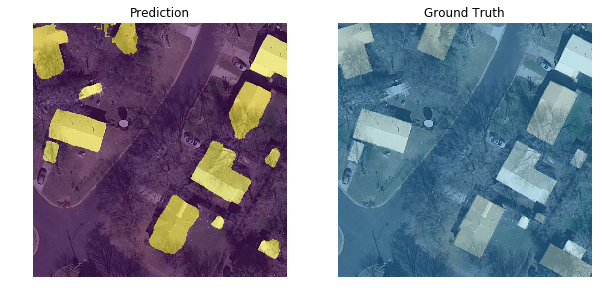

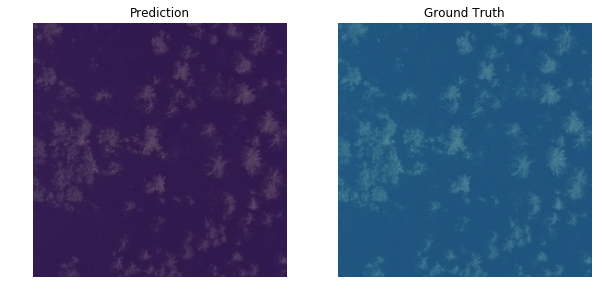

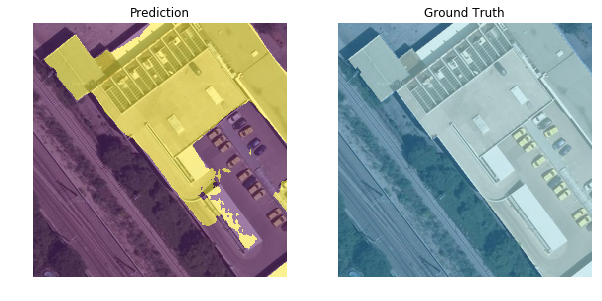

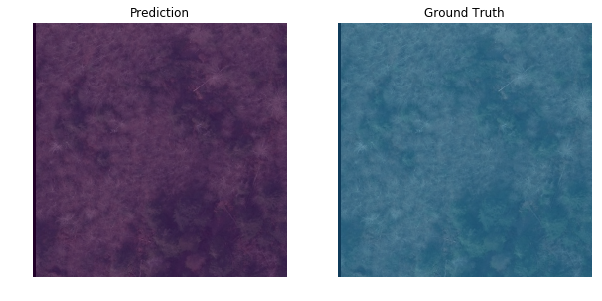

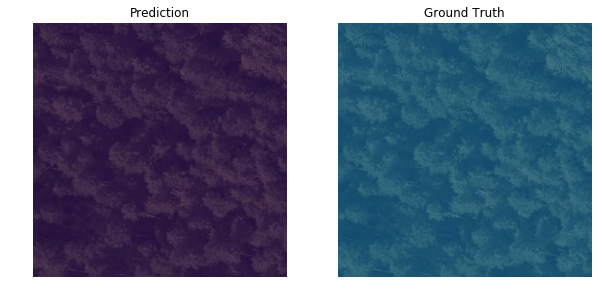

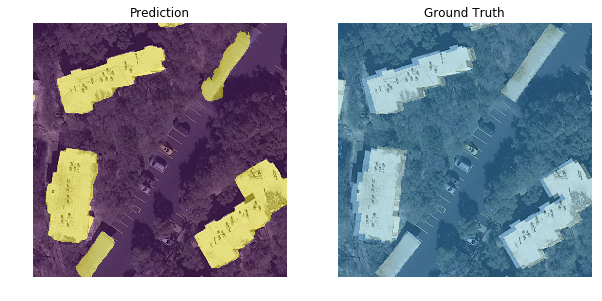

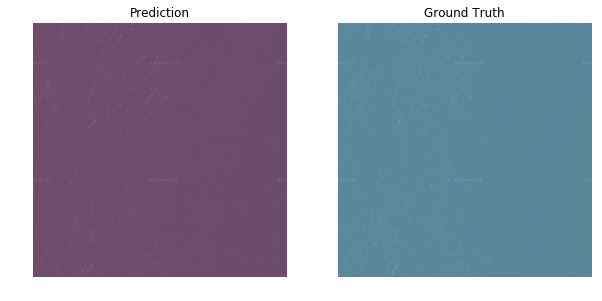

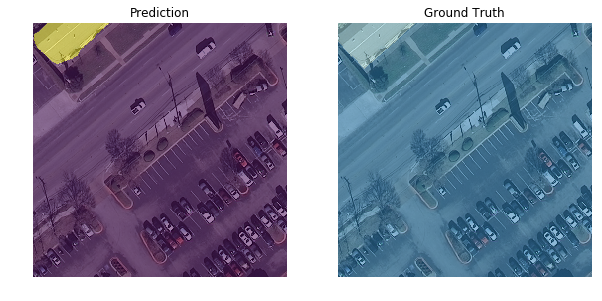

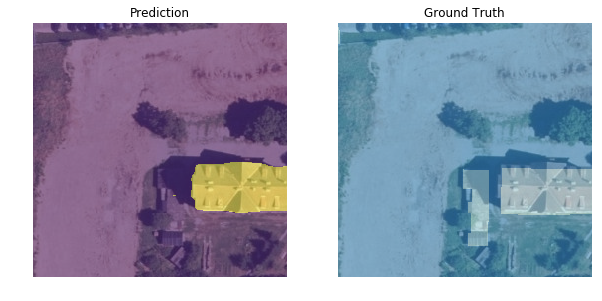

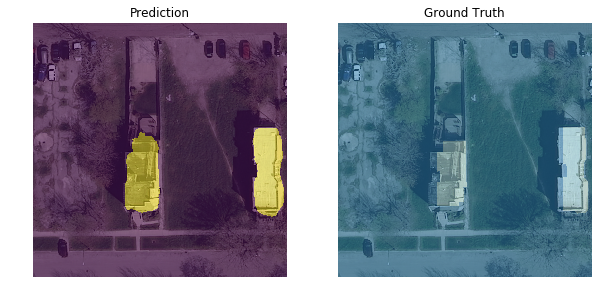

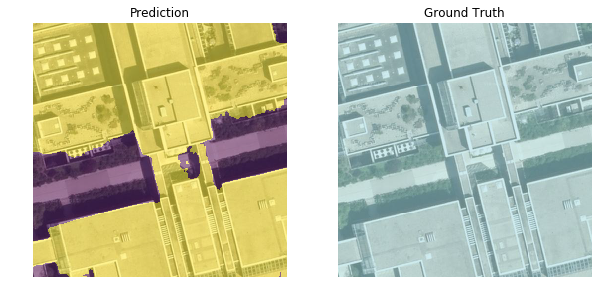

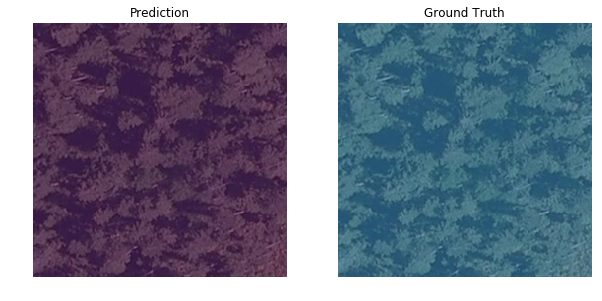

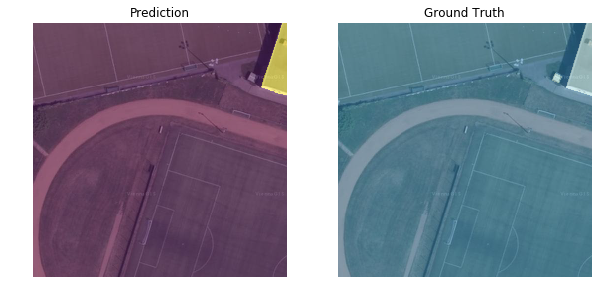

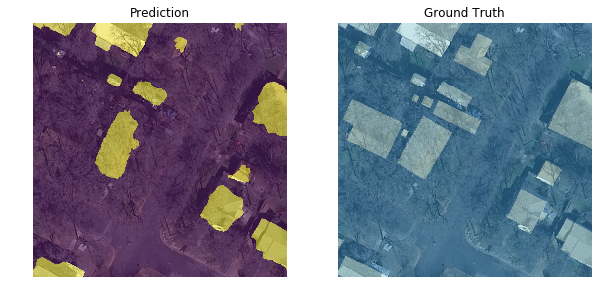

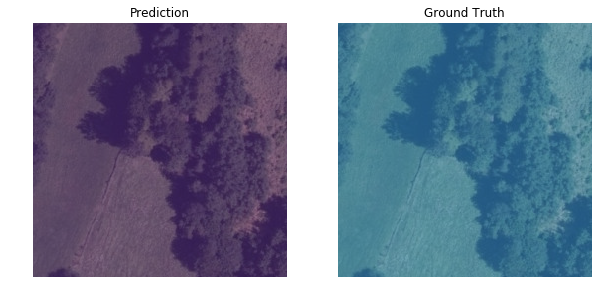

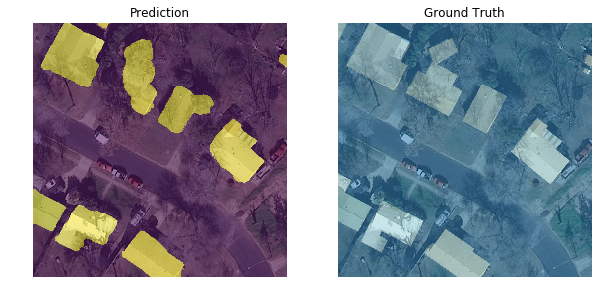

In [0]:
# Comparing Model's prediction and ground truth values
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid()>0.50)), alpha=0.5)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.5)
    plt.show()

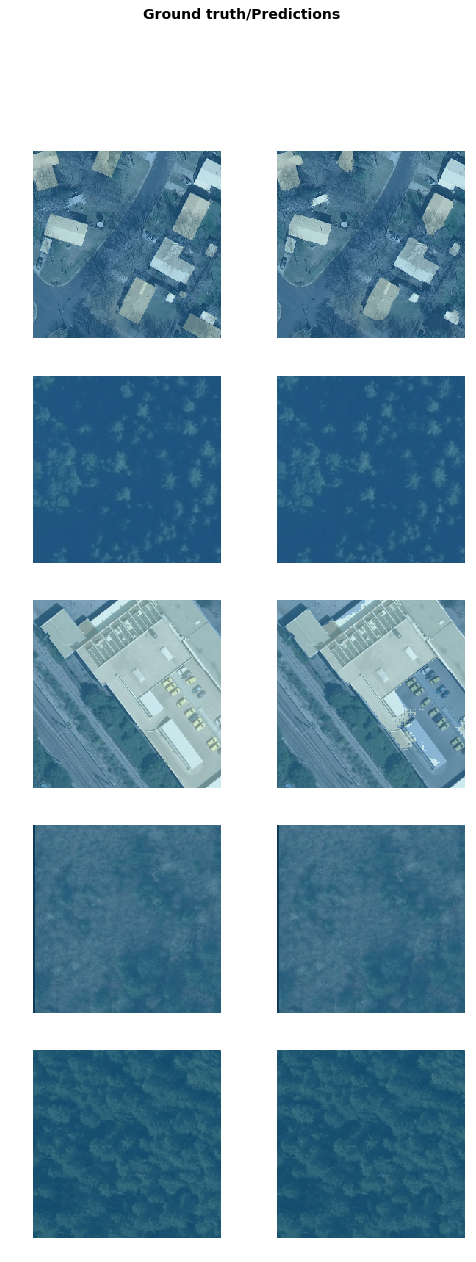

In [0]:
# Another predefined approach
learn.show_results()